## Constructing a Synthetic NMR Well-log using Machine Learning


### By Abhishek Bihani

### Final Project for PGE 383 – Subsurface Machine Learning taught by Dr. Michael Pyrcz

### Hildebrand Department of Petroleum and Geosystems Engineering

### The University of Texas at Austin

****


**Executive Summary:** 

The nuclear magnetic resonance (NMR) log is a useful tool to understand lithological information such as the variation of pore size distribution with depth, but it may not be measured in all wells. The project attempts to predict a missing well log from other available well logs using machine learning tools, more specifically an NMR well log from the measured Gamma Ray (GR) log, Caliper log, Resistivity log, and the interpreted porosity from one well at the Keathley Canyon in the Gulf of Mexico. The constructed model is then used to predict the NMR log at Walker Ridge in Gulf of Mexico, which is another nearby site of methane hydrate accumulation. 

In Keathley Canyon Block 151 (KC-151), the analyzed well was drilled and logged during Leg I of the U.S. Department of Energy/Chevron Gas Hydrate Joint Industry Project (JIP) (Ruppel et al., 2008). At Walker Ridge 313 (WR-313), the analyzed well was drilled and logged during JIP Leg II (Collett et al., 2012). The raw well logs for KC-151 are available [here](http://mlp.ldeo.columbia.edu/data/ghp/JIP1/KC151-2/index.html?) and for WR-313 are available [here](http://mlp.ldeo.columbia.edu/data/ghp/JIP2/WR313-H/). The processed well logs used in this project for KC-151 are available [here](https://github.com/abhishekdbihani/synthetic_well-log_polynomial_regression/blob/master/KC151_logs.csv) and for WR-313 are available [here](https://github.com/abhishekdbihani/synthetic_well-log_polynomial_regression/blob/master/WR313H_logs.csv).

**Approach:**

1) For an easier characterization of the NMR data, the NMR log, i.e. relaxation time distribution was converted into Mean of T2 (MLT2) and Standard Deviation of T2 (SDT2) which are considered as the two response features to be predicted. The other well logs: GR, Caliper, Resistivity, and the interpreted porosity are the predictor features used to train the model.

2) An initial analysis is conducted on the well logs to check the univariate and bivariate distributions of the data, and the well-logs are plotted with depth. 

3) Then a linear regression is conducted for both MLT2 and SDT2 using the other predictor variables to observe the behavior with a basic model. It is seen that the linear regression could not capture the response behavior well due to noise, i.e. short-distance variations as well as non-linearities in the data relationships. 

4) This is followed by feature standardization before applying more complex models to reduce effect of outliers and predictor features having different units. Feature ranking was conducted to compare the order in which predictor variables affect the response variables.

5) Then, the logs are processed to reduce noise, and after a train-test split, polynomial regression modeling is conducted to predict the NMR log at Keathley Canyon until a good fit is obtained.

6) Finally, the trained model is used to predict the NMR log at Walker Ridge where it was not recorded.

*Note: The codes and procedures used for this project have been adapted from the workflows followed by Dr. Pyrcz in the class (Pyrcz, 2019 a, b, c, d) and my Master's thesis (Bihani, 2016).*


**Assumptions:**

1) The conditions at both KC-151 and WR-313 locations are assumed to be similar enough so the same model can be applied.

2) The model is assumed to be sufficiently trained to make predictions but can be improved if more training data is available.

3) The porosity has been calculated from the bulk density log since porosity is a function of the grain density of the formation (2.65 gm/cm3 in sands, 2.70 gm/cm3 in clays; Daigle et al., 2015) and of the pore-filled fluid (assumed to be water, with a density of 1.03 gm/cm3; Daigle et al., 2015).

4) During polynomial regression, it was assumed that all the relationships between predictors and response features could be captured by basis expansion until the 3rd power.
 

**References:**

Bihani A., Pore Size Distribution and Methane Equilibrium Conditions at Walker Ridge Block 313, Northern Gulf of Mexico, M.S. thesis, University of Texas, Austin, Texas, 2016. doi:10.15781/T2542J80Z

Collett, T. S., Lee, M. W., Zyrianova, M. V., Mrozewski, S. a., Guerin, G., Cook, A. E., and Goldberg, D. S. (2012). Gulf of Mexico Gas Hydrate Joint Industry Project Leg II logging- while-drilling data acquisition and analysis. Marine and Petroleum Geology, 34(1),41-61, doi:10.1016/j.marpetgeo.2011.08.003

Daigle, H., Cook, A., and Malinverno, A. (2015). Permeability and porosity of hydrate- bearing sediments in the northern Gulf of Mexico. Marine and Petroleum 	Geology, 68, 	551–564, doi:10.1016/j.marpetgeo.2015.10.004

Pyrcz M., (2019a) Feature Selection for Subsurface Data Analytics in Python. Retrieved December 5, 2019, from https://github.com/GeostatsGuy/PythonNumericalDemos/blob/master/SubsurfaceDataAnalytics_Feature_Ranking.ipynb

Pyrcz M., (2019b) Principal Component Analysis for Subsurface Data Analytics in Python. Retrieved December 5, 2019, from
https://github.com/GeostatsGuy/PythonNumericalDemos/blob/master/SubsurfaceDataAnalytics_PCA.ipynb

Pyrcz M., (2019c) Time Series Analysis for Subsurface Modeling in Python. Retrieved December 5, 2019, from
https://github.com/GeostatsGuy/PythonNumericalDemos/blob/master/SubsurfaceDataAnalytics_TimeSeries.ipynb

Pyrcz M., (2019d) Polygonal Regression for Subsurface Data Analytics in Python. Retrieved December 5, 2019, from
https://github.com/GeostatsGuy/PythonNumericalDemos/blob/master/SubsurfaceDataAnalytics_PolygonalRegression.ipynb

Ruppel, C., Boswell, R., and Jones, E. (2008). Scientific results from Gulf of Mexico Gas Hydrates Joint Industry Project Leg 1 drilling: Introduction and overview. Marine and Petroleum Geology, 25(9), 819–829. doi:10.1016/j.marpetgeo.2008.02.007

*****


### Inital analysis

First all the packages required for the workflow are imported

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from pandas import DataFrame
import pandas.plotting as pd_plot           # matrix scatter plots
import scipy
from scipy import linalg                  # for linear regression
from scipy import stats                   # summary statistics
import seaborn as sns                     # for matrix scatter plots
from sklearn import linear_model
from sklearn import preprocessing
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression           # linear regression with scikit learn
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split        # train and test split
import geostatspy.GSLIB as GSLIB          # GSLIB utilies, visualization and wrapper
import geostatspy.geostats as geostats    # GSLIB methods convert to Python 
from sklearn.preprocessing import StandardScaler

The working directory is set to the address where data is located and the well logs for Keathley Canyon are imported to train the model

In [2]:
df = pd.read_csv(r'C:\Users\Abhishek\Desktop\python regression\KC151_logs.csv')

The table below shows the variation of the logs with depth given in meters below sea-floor (mbsf).

In [3]:
#Looking at the data
df.head(n=10)

,Depth,GR,Porosity,Caliper,Ring resistivity,MLT2_all_original,SD_all_original
0,4.1388,91.765125,0.792482,26.577798,0.6812,1.996562,0.865698
1,4.2912,91.795654,0.792422,26.159968,0.6826,1.932333,0.866630
2,4.4436,93.512601,0.793198,25.914604,0.6819,1.968189,0.865522
3,4.5960,95.042114,0.785680,26.548334,0.7107,1.977933,0.865478
4,4.7484,94.909526,0.781504,27.045920,0.7157,1.937783,0.866366
5,4.9008,96.206315,0.782697,26.815796,0.6928,1.956473,0.865721
6,5.0532,101.210934,0.785442,27.146758,0.6613,1.975697,0.865478
7,5.2056,105.150925,0.786038,26.992072,0.7366,1.968323,0.865521
8,5.3580,103.661835,0.787768,27.026108,0.7402,1.981202,0.865487
9,5.5104,101.736457,0.781742,26.667714,0.7147,1.969500,0.865510


#### Summary statistics

The summary statistics show that all the variables have values in the expected range and don't require truncation. 

In [4]:
#Summary statistics
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Depth,2765.0,214.755600,121.665655,4.138800,109.447200,214.755600,320.064000,425.372400
GR,2765.0,100.827702,10.508588,18.468972,95.277503,101.841442,107.590759,126.309943
Porosity,2765.0,0.476067,0.069298,0.359964,0.429236,0.459905,0.502566,0.793198
Caliper,2765.0,22.541963,1.136227,20.896072,21.775674,22.179280,22.951186,29.315156
Ring resistivity,2765.0,1.104760,0.326224,0.269000,0.932100,1.033000,1.181100,3.579700
MLT2_all_original,2765.0,1.619934,0.240224,1.126192,1.438629,1.617906,1.769789,2.378660
SD_all_original,2765.0,0.962933,0.083712,0.865477,0.893472,0.937476,1.019269,1.213652



***
#### Defining the minimum and maximum of variables

In [5]:
#Defining the minimum and maximum of variables for plotting figures

pormin = df['Porosity'].min(); pormax = df['Porosity'].max(); porname = 'Porosity (v/v)'; portitle = 'Porosity' # user specified min and max values, and labels for plotting
grmin = df['GR'].min(); grmax = df['GR'].max(); grname = 'Gamma Ray (GAPI)'; grtitle = 'Gamma Ray Log' 
calmin = df['Caliper'].min(); calmax = df['Caliper'].max(); calname = 'Caliper (cm)'; caltitle = 'Caliper Log' 
resmin = df['Ring resistivity'].min(); resmax = df['Ring resistivity'].max(); resname = 'Ring resistivity (ohm-m)'; restitle = 'Ring resistivity Log' 
mlt2min = df['MLT2_all_original'].min(); mlt2max = df['MLT2_all_original'].max(); mlt2name = 'Mean Log of T2 (log[ms])'; mlt2title = 'Mean Log of T2 (NMR)'
sdt2min = df['SD_all_original'].min(); sdt2max = df['SD_all_original'].max(); sdt2name = 'Standard Deviation of T2 (log[ms])'; sdt2title = 'Standard Deviation of T2 (NMR)' 
depthmin = df['Depth'].min(); depthmax = df['Depth'].max(); depthname = 'Depth (mbsf)'; depthtitle = 'Depth in meters below sea-floor (mbsf)' 

#### Plotting well logs with depth

All the well-logs are plotted with depth to see the spatial variation

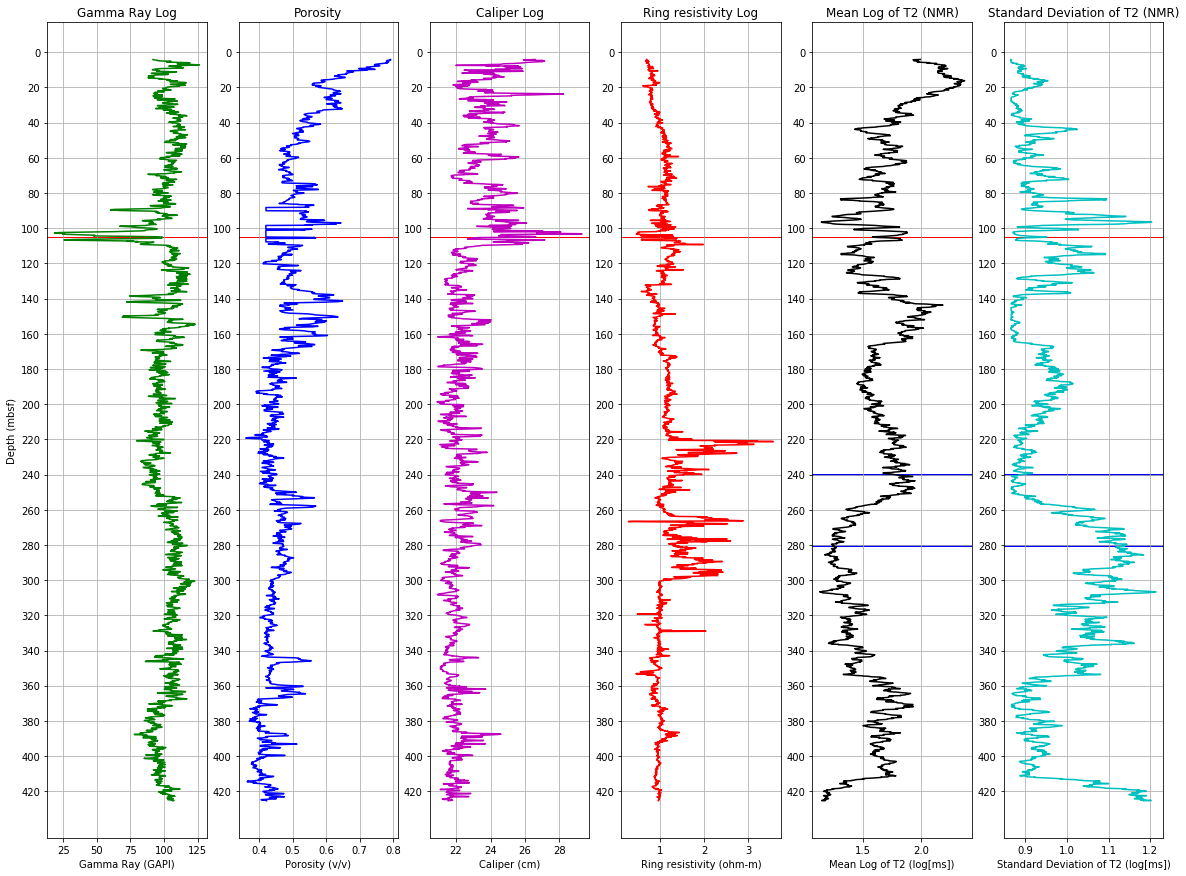

In [6]:
# Plot logs vs depth

plt.subplot(161)
plt.plot(df['GR'].values, df['Depth'].values,'g')
#plt.yscale('linear')
plt.title(grtitle)
plt.xlabel(grname)
plt.ylabel(depthname)
plt.yticks(np.arange(0, max(df['Depth'].values), 20.0))
plt.grid(True)
plt.gca().invert_yaxis()
plt.arrow(0,105,150,0,width=0.5,color='red',head_length=0.0,head_width=0.0)

plt.subplot(162)
plt.plot(df['Porosity'].values, df['Depth'].values,'b')
#plt.yscale('linear')
plt.title(portitle)
plt.xlabel(porname)
plt.yticks(np.arange(0, max(df['Depth'].values), 20.0))
plt.grid(True)
plt.gca().invert_yaxis()
plt.arrow(0,105,150,0,width=0.5,color='red',head_length=0.0,head_width=0.0)

plt.subplot(163)
plt.plot(df['Caliper'].values, df['Depth'].values,'m')
#plt.yscale('linear')
plt.title(caltitle)
plt.xlabel(calname)
plt.yticks(np.arange(0, max(df['Depth'].values), 20.0))
plt.grid(True)
plt.gca().invert_yaxis()
plt.arrow(0,105,150,0,width=0.5,color='red',head_length=0.0,head_width=0.0)

plt.subplot(164)
plt.plot(df['Ring resistivity'].values, df['Depth'].values,'r')
#plt.yscale('linear')
plt.title(restitle)
plt.xlabel(resname)
plt.yticks(np.arange(0, max(df['Depth'].values), 20.0))
plt.grid(True)
plt.gca().invert_yaxis()
plt.arrow(0,105,150,0,width=0.5,color='red',head_length=0.0,head_width=0.0)

plt.subplot(165)
plt.plot(df['MLT2_all_original'].values, df['Depth'].values,'k')
#plt.yscale('linear')
plt.title(mlt2title)
plt.xlabel(mlt2name)
plt.yticks(np.arange(0, max(df['Depth'].values), 20.0))
plt.grid(True)
plt.gca().invert_yaxis()
plt.arrow(0,105,150,0,width=0.5,color='red',head_length=0.0,head_width=0.0)
plt.arrow(0,240.2,150,0,width=0.5,color='blue',head_length=0.0,head_width=0.0)
plt.arrow(0,280.2,150,0,width=0.5,color='blue',head_length=0.0,head_width=0.0)

plt.subplot(166)
plt.plot(df['SD_all_original'].values, df['Depth'].values,'c')
#plt.yscale('linear')
plt.title(sdt2title)
plt.xlabel(sdt2name)
plt.yticks(np.arange(0, max(df['Depth'].values), 20.0))
plt.grid(True)
plt.gca().invert_yaxis()
plt.arrow(0,105,150,0,width=0.5,color='red',head_length=0.0,head_width=0.0)
plt.arrow(0,240.2,150,0,width=0.5,color='blue',head_length=0.0,head_width=0.0)
plt.arrow(0,280.2,150,0,width=0.5,color='blue',head_length=0.0,head_width=0.0)

plt.gcf().set_size_inches(20, 15)

From the abnormally large caliper at depths <105 mbsf we can infer that data is not reliable and hence is removed from further analysis.

In [7]:
#Remove all values < 105 mbsf as poor quality data

df_new = df[df['Depth'] > 105]
#Summary statistics of updated data
df_new.describe()

,Depth,GR,Porosity,Caliper,Ring resistivity,MLT2_all_original,SD_all_original
count,2103.000000,2103.000000,2103.000000,2103.000000,2103.000000,2103.000000,2103.000000
mean,265.200000,100.936861,0.453905,22.110107,1.142800,1.570738,0.974878
std,92.541567,9.094375,0.046006,0.680386,0.352292,0.209189,0.086409
min,105.027600,25.516154,0.359964,20.896072,0.269000,1.126192,0.865477
25%,185.113800,95.153211,0.424254,21.672042,0.943200,1.399801,0.901022
50%,265.200000,101.352258,0.443496,21.999448,1.036400,1.578038,0.953013
75%,345.286200,107.389828,0.474553,22.388322,1.208600,1.726435,1.040301
max,425.372400,123.092765,0.649344,27.156410,3.579700,2.191352,1.213652


The summary statistics show that all the variables have values in the expected range and don't require truncation.
***

#### NMR Log variables

From the measured NMR log, the transverse relaxation time (T2) was calculated since it measures different amplitudes for the various T2 values according to the formation and fluid at any particular depth. For an easier characterization of the NMR data, the relaxation time distribution was converted into the Mean (MLT2) and Standard Deviation (SDT2) after taking a log.

Note: The distributions are shown as normal distributions for ease of understanding but may not be so in actuality.

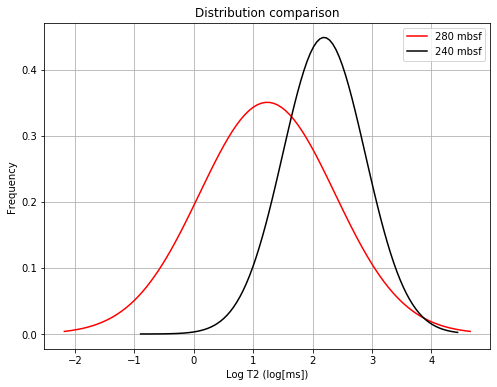

In [8]:
#low MLT2 and high SDT2
MLT2_280=df.loc[(df['Depth']>280) & (df['Depth']<280.2), 'MLT2_all_original']
SDT2_280=df.loc[(df['Depth']>280) & (df['Depth']<280.2), 'SD_all_original']

#high MLT2 and low SDT2
MLT2_240=df.loc[(df['Depth']>240) & (df['Depth']<240.2), 'MLT2_all_original']
SDT2_240=df.loc[(df['Depth']>240) & (df['Depth']<240.2), 'SD_all_original']

#Plotting distributions
x = np.linspace(MLT2_280 - 3*SDT2_280, MLT2_280 + 3*SDT2_280, 100)
plt.plot(x, stats.norm.pdf(x, MLT2_280, SDT2_280),'r',label='280 mbsf')
x1 = np.linspace(MLT2_240 - 3*SDT2_240, MLT2_240 + 3*SDT2_240, 100)
plt.plot(x1, stats.norm.pdf(x, MLT2_240, SDT2_240),'k',label='240 mbsf')
plt.title('Distribution comparison')
plt.xlabel('Log T2 (log[ms])')
plt.ylabel('Frequency')
plt.legend()
plt.grid(True)
plt.gcf().set_size_inches(8, 6)

In the above figure, at 240 mbsf, a larger mean (MLT2) and smaller standard deviation (SDT2) of the T2 distribution corresponds to a larger and well-sorted pore size.
At 280 mbsf, a smaller mean (MLT2) and larger standard deviation (SDT2) of the T2 distribution corresponds to a smaller and poorly-sorted pore size.
***

Updating the minimum and maximum of variables for plotting figures.

In [9]:
pormin = df_new['Porosity'].min(); pormax = df_new['Porosity'].max(); porname = 'Porosity (v/v)'; portitle = 'Porosity' # user specified min and max values, and labels for plotting
grmin = df_new['GR'].min(); grmax = df_new['GR'].max(); grname = 'Gamma Ray (GAPI)'; grtitle = 'Gamma Ray Log' 
calmin = df_new['Caliper'].min(); calmax = df_new['Caliper'].max(); calname = 'Caliper (cm)'; caltitle = 'Caliper Log' 
resmin = df_new['Ring resistivity'].min(); resmax = df_new['Ring resistivity'].max(); resname = 'Ring resistivity (ohm-m)'; restitle = 'Ring resistivity Log' 
mlt2min = df_new['MLT2_all_original'].min(); mlt2max = df_new['MLT2_all_original'].max(); mlt2name = 'Mean Log of T2 (log[ms])'; mlt2title = 'Mean Log of T2 (NMR)' 
sdt2min = df_new['SD_all_original'].min(); sdt2max = df_new['SD_all_original'].max(); sdt2name = 'Standard Deviation of T2 (log[ms])'; sdt2title = 'Standard Deviation of T2 (NMR)' 
depthmin = df_new['Depth'].min(); depthmax = df_new['Depth'].max(); depthname = 'Depth (mbsf)'; depthtitle = 'Depth in meters below sea-floor (mbsf)' 


#### Plotting univariate distributions

The univariate distributions show that there are no obvious missing data, significant truncations or spikes. This part of workflow adapted from Pyrcz (2019 a).

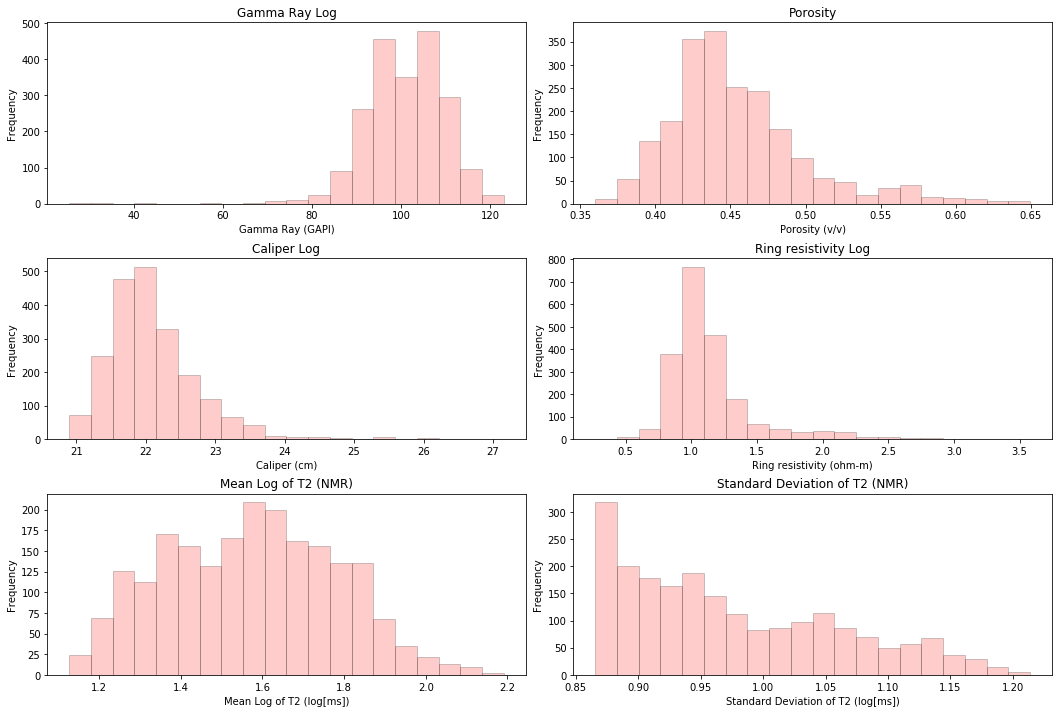

In [10]:
#Plotting univariate distributions

plt.subplot(321)
GSLIB.hist_st(df_new['GR'].values, grmin, grmax, log=False, cumul = False,bins=20, weights = None, xlabel=grname, title=grtitle)

plt.subplot(322)
GSLIB.hist_st(df_new['Porosity'].values,pormin,pormax,log=False,cumul = False,bins=20,weights = None,xlabel=porname,title=portitle)

plt.subplot(323)
GSLIB.hist_st(df_new['Caliper'].values,calmin,calmax,log=False,cumul = False,bins=20,weights = None,xlabel=calname,title=caltitle)

plt.subplot(324)
GSLIB.hist_st(df_new['Ring resistivity'].values,resmin,resmax,log=False,cumul = False,bins=20,weights = None, xlabel=resname, title=restitle)

plt.subplot(325)
GSLIB.hist_st(df_new['MLT2_all_original'].values,mlt2min,mlt2max,log=False,cumul = False,bins=20,weights = None, xlabel=mlt2name,title=mlt2title)

plt.subplot(326)
GSLIB.hist_st(df_new['SD_all_original'].values,sdt2min,sdt2max,log=False,cumul = False,bins=20,weights = None, xlabel=sdt2name,title=sdt2title)


plt.subplots_adjust(wspace=0.1, hspace=0.3)

plt.gcf().set_size_inches(18, 12)
#plt.savefig('hist_Porosity_Multiple_bins.tif',dpi=600,bbox_inches="tight")
plt.show()

#### Plotting bivariate distributions

The bivariate distributions shows complex relationships between the different variables. The plot between MLT2 and SDT2 can be ignored due to known existing correlation.

<Figure size 1440x1440 with 0 Axes>

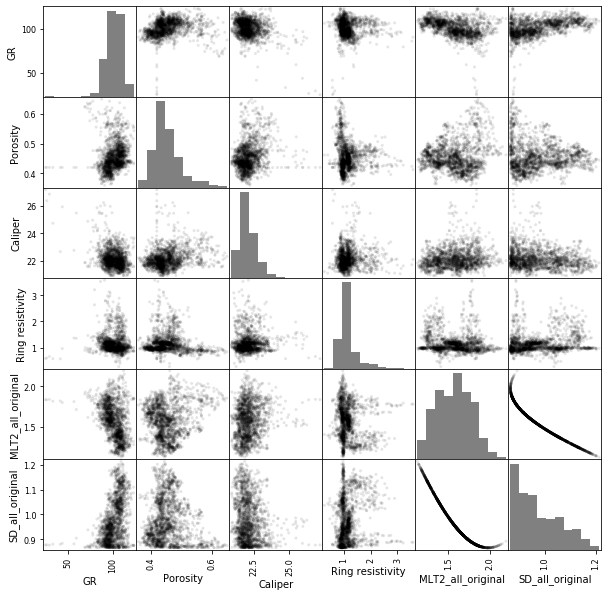

In [11]:
#Plotting bivariate distributions

plt.figure(figsize=(20,20)) 
pd_plot.scatter_matrix(df_new.drop('Depth', axis = 1), alpha = 0.1,              # pandas matrix scatter plot
    figsize=(6, 6),color = 'black', hist_kwds={'color':['grey']})
plt.gcf().set_size_inches(10, 10)
plt.show()

#### Linear regression

***
For initial understanding, a linear regression is conducted for MLT2 and SDT2 with other variables

In [12]:
#linear regression for MLT2 with all data

X1 = df_new[['GR','Porosity','Caliper','Ring resistivity']] # here we have 4 input variables for multiple regression. If you just want to use one variable for simple linear regression, then use X = df['Interest_Rate'] for example.Alternatively, you may add additional variables within the brackets
Y1 = df_new['MLT2_all_original'] # output variable (what we are trying to predict)


lin_reg = LinearRegression() 
lin_reg.fit(X1, Y1) 
MLT2_pred=lin_reg.predict(X1)

print('Coefficient of regression (R2) for MLT2')
r2_score(Y1, MLT2_pred)

Coefficient of regression (R2) for MLT2


0.24864083883019727

The MLT2 regression results with low R2 and low coefficients shows that standardization and further processing is required

In [13]:
#linear regression for SDT2 with all data

X2 = df_new[['GR', 'Porosity', 'Caliper', 'Ring resistivity']] # here we have 4 input variables for multiple regression. If you just want to use one variable for simple linear regression, then use X = df['Interest_Rate'] for example.Alternatively, you may add additional variables within the brackets
Y2 = df_new['SD_all_original'] # output variable (what we are trying to predict)

lin_reg.fit(X2, Y2) 
SDT2_pred=lin_reg.predict(X2)

print('Coefficient of regression (R2) for SDT2')
r2_score(Y2, SDT2_pred)

Coefficient of regression (R2) for SDT2


0.2658736910885142

#### Plot comparisons

The SDT2 regression results with low R2 and low coefficients shows that standardization and further processing is required

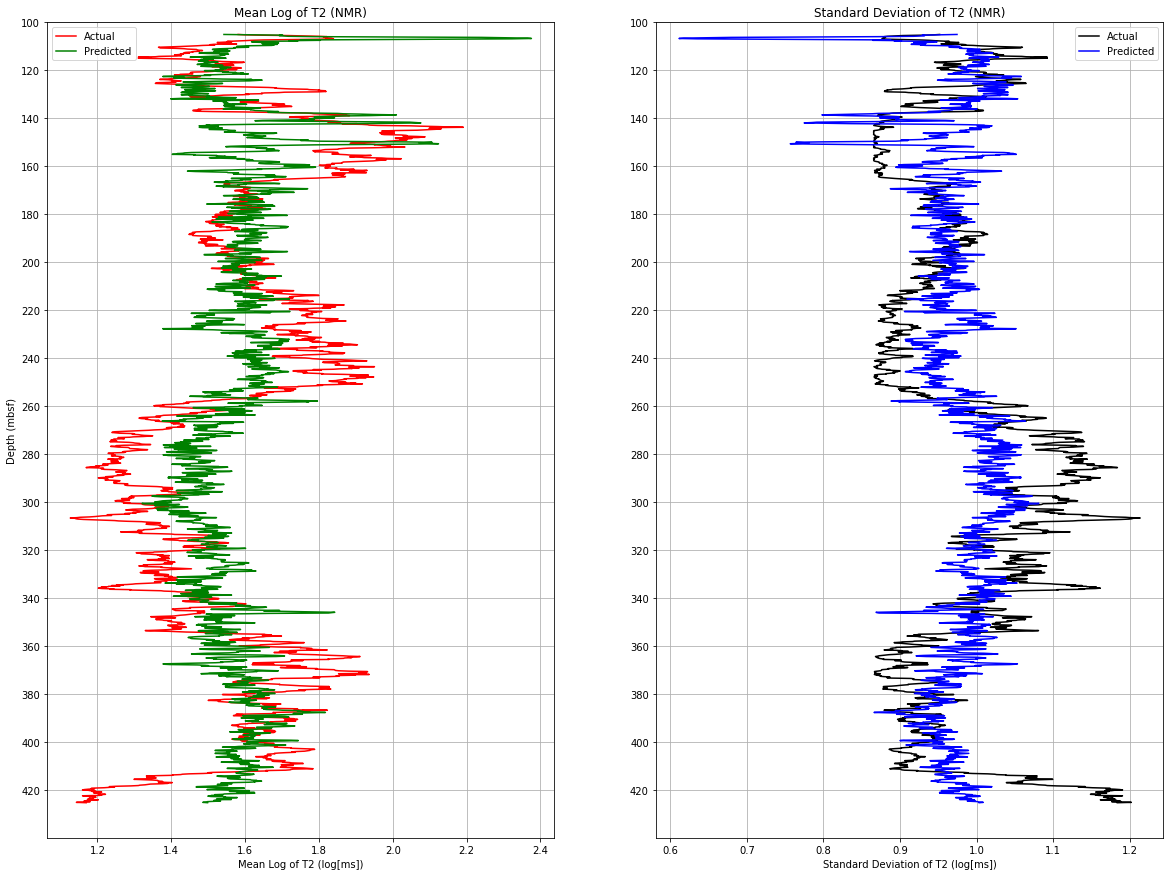

In [14]:
#Comparison between original and predicted MLT2 and SDT2

plt.subplot(121)
plt.plot(df_new['MLT2_all_original'].values, df_new['Depth'].values,'r',label='Actual')
plt.plot(MLT2_pred, df_new['Depth'].values,'g',label='Predicted')
plt.title(mlt2title)
plt.xlabel(mlt2name)
plt.ylabel(depthname)
plt.yticks(np.arange(0, max(df_new['Depth'].values), 20.0))
plt.grid(True)
plt.gca().set_ylim([100,440])
plt.gca().invert_yaxis()
plt.legend()

plt.subplot(122)
plt.plot(df_new['SD_all_original'].values, df_new['Depth'].values,'k',label='Actual')
plt.plot(SDT2_pred, df_new['Depth'].values,'b',label='Predicted')
plt.title(sdt2title)
plt.xlabel(sdt2name)
plt.yticks(np.arange(0, max(df_new['Depth'].values), 20.0))
plt.grid(True)
plt.gca().set_ylim([100,440])
plt.gca().invert_yaxis()
plt.legend()

plt.gcf().set_size_inches(20, 15)

The log comparisons show that the regression cannot capture the behavior well, possibly due to lack of standardization, resolution issues and non-linearity.
***
#### Standardization

The variables are standardized for further analysis. This was done before applying more complex models to reduce effect of outliers and predictor features having different units.

In [15]:
#Standardization

scaler = StandardScaler()                     # instantiate the scaler 
dfS = df_new.copy()
depth=df_new['Depth']
MLT2=df_new['MLT2_all_original']
SDT2=df_new['SD_all_original']
scaler.fit(dfS.drop('Depth',axis=1))
dfS1 = scaler.transform(dfS.drop('Depth', axis = 1)) # standardize all the values extracted from the DataFrame except Depth
transformer_MLT2 = scaler.fit(MLT2.values.reshape(-1, 1))
dfS = pd.DataFrame(dfS1, index = dfS.index, columns = dfS.drop('Depth', axis = 1).columns)
dfS.insert(0, 'Depth', depth)
scaler2 = StandardScaler()                     
transformer_SDT2 = scaler2.fit(SDT2.values.reshape(-1, 1))
dfS.describe()

,Depth,GR,Porosity,Caliper,Ring resistivity,MLT2_all_original,SD_all_original
count,2103.000000,2.103000e+03,2.103000e+03,2.103000e+03,2.103000e+03,2.103000e+03,2.103000e+03
mean,265.200000,1.003213e-15,5.241752e-16,-1.984939e-15,-6.998153e-16,8.026548e-16,-9.086618e-16
std,92.541567,1.000238e+00,1.000238e+00,1.000238e+00,1.000238e+00,1.000238e+00,1.000238e+00
min,105.027600,-8.295089e+00,-2.042431e+00,-1.784757e+00,-2.480920e+00,-2.125604e+00,-1.266392e+00
25%,185.113800,-6.361104e-01,-6.446612e-01,-6.440013e-01,-5.667103e-01,-8.173398e-01,-8.549354e-01
50%,265.200000,4.568705e-02,-2.263031e-01,-1.626808e-01,-3.020939e-01,3.490276e-02,-2.531072e-01
75%,345.286200,7.097245e-01,4.489074e-01,4.090040e-01,1.868219e-01,7.444675e-01,7.573171e-01
max,425.372400,2.436800e+00,4.249156e+00,7.418584e+00,6.918925e+00,2.967474e+00,2.763967e+00


The values after standardization have a mean of 0 and std of 1 (except depth which is the reference)


In [16]:
#Saving variables for inverse scaling
mlt2mean = df_new['MLT2_all_original'].mean();
mlt2sd = df_new['MLT2_all_original'].std();
sdt2mean = df_new['SD_all_original'].mean();
sdt2sd = df_new['SD_all_original'].std();

#### Plotting bivariate distributions

The bivariate distributions still shows complex relationships between the different variables. The plot between MLT2 and SDT2 can be ignored due to known existing correlation.

<Figure size 1440x1440 with 0 Axes>

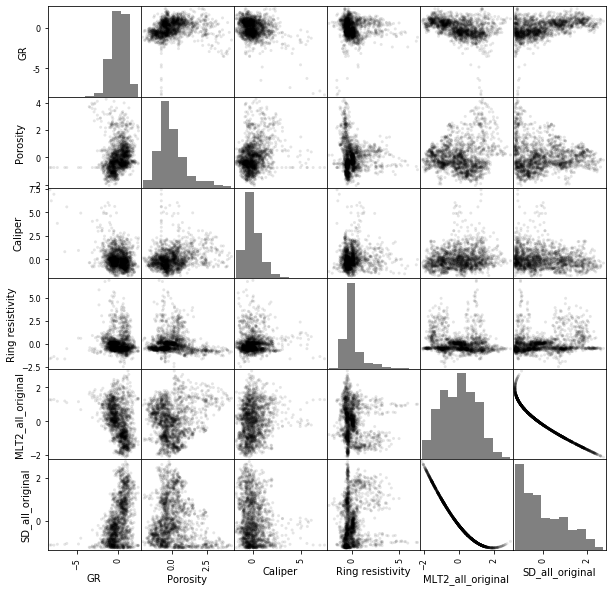

In [17]:
#Plotting bivariate distributions

plt.figure(figsize=(20,20)) 
pd_plot.scatter_matrix(dfS.drop('Depth', axis = 1), alpha = 0.1,              # pandas matrix scatter plot
    figsize=(6, 6),color = 'black', hist_kwds={'color':['grey']})
plt.gcf().set_size_inches(10, 10)
plt.show()


***

### Feature ranking

This part of workflow adapted from Pyrcz (2019 a).
***

#### Covariance 

Pairwise covariance provides a measure of the strength of the linear relationship between each predictor feature and the response feature but varies in magnitude according to units. Not seen in this case due to standardization.

In [18]:
#Find covariance
covariance1 = dfS.iloc[:,1:7].cov().iloc[4,:4]
covariance2 = dfS.iloc[:,1:7].cov().iloc[5,:4]

print(covariance1)
print(covariance2)

GR                 -0.429027
Porosity            0.126932
Caliper             0.157852
Ring resistivity   -0.125320
Name: MLT2_all_original, dtype: float64
GR                  0.465741
Porosity           -0.073461
Caliper            -0.167173
Ring resistivity    0.130834
Name: SD_all_original, dtype: float64


#### Correlation coefficient

Pairwise correlation coefficient provides a measure of the strength of the linear relationship between each predictor feature and the response feature.

In [19]:
#Find pairwise correlation coefficient
correlation1 = dfS.iloc[:,1:7].corr().iloc[4,:4]
correlation2 = dfS.iloc[:,1:7].corr().iloc[5,:4]

print(correlation1)
print(correlation2)

GR                 -0.428823
Porosity            0.126871
Caliper             0.157777
Ring resistivity   -0.125260
Name: MLT2_all_original, dtype: float64
GR                  0.465520
Porosity           -0.073426
Caliper            -0.167093
Ring resistivity    0.130772
Name: SD_all_original, dtype: float64


#### Rank correlation coefficient

The rank correlation coefficient applies the rank transform to the data prior to calculating the correlation coefficent and thus relaxing the linear assumption

In [20]:
#Find Pairwise Spearman rank correlation coefficient
rank_correlation, rank_correlation_pval = stats.spearmanr(dfS.iloc[:,1:7]) # calculate the range correlation coefficient

rank_correlation1 = rank_correlation[:,4][:4]
rank_correlation_pval1 = rank_correlation_pval[:,4][:4]

print('MLT2')
print('rank_correlation')
print(rank_correlation1)
print('rank_correlation_pval')
print(rank_correlation_pval1)

rank_correlation2 = rank_correlation[:,5][:4]
rank_correlation_pval2 = rank_correlation_pval[:,5][:4]
print('SDT2')
print('rank_correlation')
print(rank_correlation2)
print('rank_correlation_pval')
print(rank_correlation_pval2)

MLT2
rank_correlation
[-0.4794834  -0.02182215  0.15249551 -0.15942119]
rank_correlation_pval
[2.36810834e-121 3.17187278e-001 2.06225357e-012 1.93021843e-013]
SDT2
rank_correlation
[ 0.48249649  0.0227079  -0.15261396  0.1585977 ]
rank_correlation_pval
[4.47998443e-123 2.97938312e-001 1.98215061e-012 2.57251013e-013]


In [21]:
#Partial Correlation in Python (clone of Matlab's partialcorr)

#This uses the linear regression approach to compute the partial correlation 
#(might be slow for a huge number of variables). The algorithm is detailed here:

# http://en.wikipedia.org/wiki/Partial_correlation#Using_linear_regression

#Taking X and Y two variables of interest and Z the matrix with all the variable minus {X, Y},
#the algorithm can be summarized as
#    1) perform a normal linear least-squares regression with X as the target and Z as the predictor
#    2) calculate the residuals in Step #1
#    3) perform a normal linear least-squares regression with Y as the target and Z as the predictor
#    4) calculate the residuals in Step #3
#    5) calculate the correlation coefficient between the residuals from Steps #2 and #4; 
#    The result is the partial correlation between X and Y while controlling for the effect of Z

#Date: Nov 2014
#Author: Fabian Pedregosa-Izquierdo, f@bianp.net
#Testing: Valentina Borghesani, valentinaborghesani@gmail.com

def partial_corr(C):
#    Returns the sample linear partial correlation coefficients between pairs of variables in C, controlling 
#    for the remaining variables in C.

#    Parameters
#    C : array-like, shape (n, p)
#        Array with the different variables. Each column of C is taken as a variable
#    Returns
#    P : array-like, shape (p, p)
#        P[i, j] contains the partial correlation of C[:, i] and C[:, j] controlling
#        for the remaining variables in C.

    C = np.asarray(C)
    p = C.shape[1]
    P_corr = np.zeros((p, p), dtype=np.float)
    for i in range(p):
        P_corr[i, i] = 1
        for j in range(i+1, p):
            idx = np.ones(p, dtype=np.bool)
            idx[i] = False
            idx[j] = False
            beta_i = linalg.lstsq(C[:, idx], C[:, j])[0]
            beta_j = linalg.lstsq(C[:, idx], C[:, i])[0]
            res_j = C[:, j] - C[:, idx].dot( beta_i)
            res_i = C[:, i] - C[:, idx].dot(beta_j)
            corr = stats.pearsonr(res_i, res_j)[0]
            P_corr[i, j] = corr
            P_corr[j, i] = corr
    return P_corr

def semipartial_corr(C): # Michael Pyrcz modified the function above by Fabian Pedregosa-Izquierdo, f@bianp.net for semipartial correlation
    C = np.asarray(C)
    p = C.shape[1]
    P_corr = np.zeros((p, p), dtype=np.float)
    for i in range(p):
        P_corr[i, i] = 1
        for j in range(i+1, p):
            idx = np.ones(p, dtype=np.bool)
            idx[i] = False
            idx[j] = False
            beta_i = linalg.lstsq(C[:, idx], C[:, j])[0]
            res_j = C[:, j] - C[:, idx].dot( beta_i)
            res_i = C[:, i] # just use the value, not a residual
            corr = stats.pearsonr(res_i, res_j)[0]
            P_corr[i, j] = corr
            P_corr[j, i] = corr
    return P_corr

#### Partial Correlation Coefficient

Partial Correlation Coefficient is a linear correlation coefficient that controls for the effects all the remaining variables, $\rho_{XY.Z}$ and $\rho_{YX.Z}$ is the partial correlation between $X$ and $Y$, $Y$ and $X$, after controlling for $Z$.

In [22]:
#Find partial correlation

partial_correlation = partial_corr(dfS.iloc[:,1:7]) # calculate the partial correlation coefficients
#print(partial_correlation)
partial_correlation1 = partial_correlation[:,4][:4] # extract a single row and remove with itself
print('MLT2')
print(partial_correlation1)

partial_correlation2 = partial_correlation[:,5][:4] # extract a single row and remove with itself
print('SDT2')
print(partial_correlation2)

MLT2
[ 0.02118995  0.21225548 -0.05970341  0.02993823]
SDT2
[ 0.15704807  0.154288   -0.05125539  0.0760084 ]


#### Semipartial Correlation Coefficient

Semipartial Correlation Coefficient is a linear correlation coefficient that controls for the effects all the remaining features, $Z$ on $X$, and then calculates the correlation between the residual $X^*-X$ and $Y$. It filters out the influence of all other predictor features on the raw response variable.

In [23]:
#Find semi-partial correlation

semipartial_correlation = semipartial_corr(dfS.iloc[:,1:7]) # calculate the partial correlation coefficients
#print(partial_correlation)
semipartial_correlation1 = semipartial_correlation[:,4][:4] # extract a single row and remove with itself
print('MLT2')
print(semipartial_correlation1)

semipartial_correlation2 = semipartial_correlation[:,5][:4] # extract a single row and remove with itself
print('SDT2')
print(semipartial_correlation2)

MLT2
[ 0.01698726  0.19389871 -0.05391151  0.02934652]
SDT2
[ 0.12745342  0.13940219 -0.04626128  0.07468878]


#### Color coded correlation matrix

The color coded correlation matrix shows that GR and Resistivity have high correlations with MLT2 (ignoring SDT2). Also, GR and Caliper have high correlations with SDT2 (ignoring MLT2)

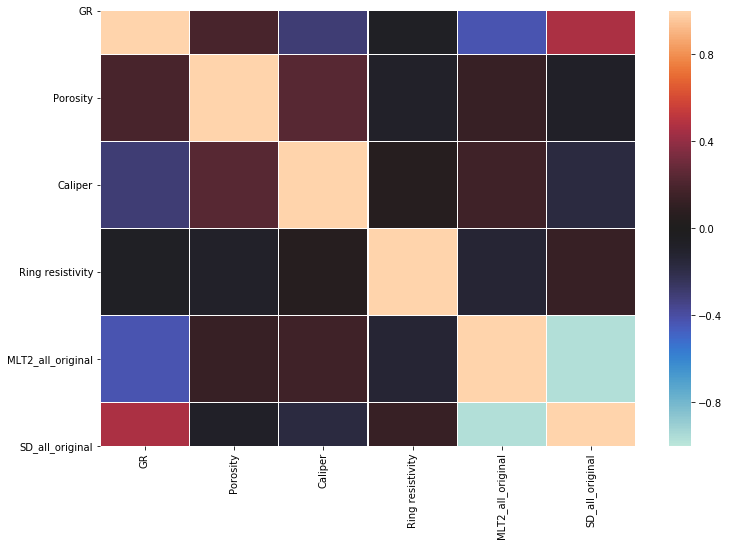

In [24]:
# Color coded correlation matrix

plt.subplot(111)                          # plot a color coded correlation matrix
sns.heatmap(dfS.iloc[:,1:7].corr(),vmin = -1.0, vmax = 1.0,linewidths=.5, fmt= '.1f', center=0)

plt.subplots_adjust(wspace=0.4, hspace=0.4)
plt.gcf().set_size_inches(12, 8)
plt.show()

#### Comparing feature ranking methods for MLT2

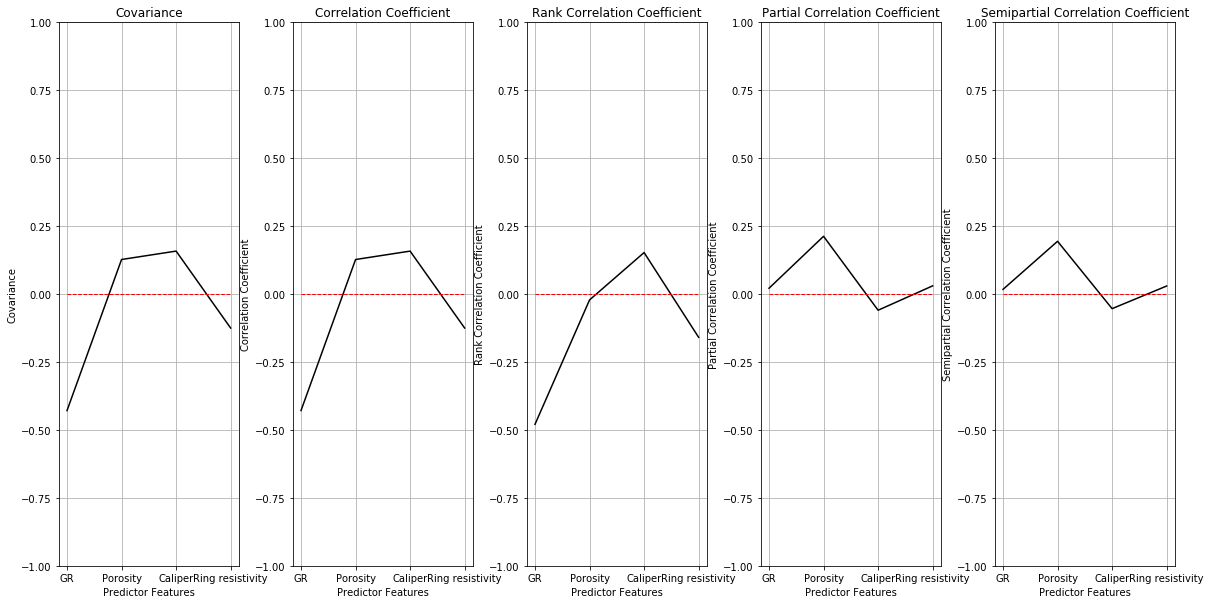

In [25]:
#Comparing different methods of feature ranking for MLT2

features = dfS.columns.values[1:][:4]

plt.subplot(151)
plt.plot(features,covariance1,color='black')
plt.plot([0.0,0.0,0.0,0.0],'r--',color='red',linewidth = 1.0)
plt.xlabel('Predictor Features')
plt.ylabel('Covariance')
t = plt.title('Covariance')
plt.ylim(-1,1)
plt.grid(True)

plt.subplot(152)
plt.plot(features,correlation1,color='black')
plt.plot([0.0,0.0,0.0,0.0],'r--',color='red',linewidth = 1.0)
plt.xlabel('Predictor Features')
plt.ylabel('Correlation Coefficient')
t = plt.title('Correlation Coefficient')
plt.ylim(-1,1)
plt.grid(True)

plt.subplot(153)
plt.plot(features,rank_correlation1,color='black')
plt.plot([0.0,0.0,0.0,0.0],'r--',color='red',linewidth = 1.0)
plt.xlabel('Predictor Features')
plt.ylabel('Rank Correlation Coefficient')
t = plt.title('Rank Correlation Coefficient')
plt.ylim(-1,1)
plt.grid(True)

plt.subplot(154)
plt.plot(features,partial_correlation1,color='black')
plt.plot([0.0,0.0,0.0,0.0],'r--',color='red',linewidth = 1.0)
plt.xlabel('Predictor Features')
plt.ylabel('Partial Correlation Coefficient')
t = plt.title('Partial Correlation Coefficient')
plt.ylim(-1,1)
plt.grid(True)

plt.subplot(155)
plt.plot(features,semipartial_correlation1,color='black')
plt.plot([0.0,0.0,0.0,0.0],'r--',color='red',linewidth = 1.0)
plt.xlabel('Predictor Features')
plt.ylabel('Semipartial Correlation Coefficient')
t = plt.title('Semipartial Correlation Coefficient')
plt.ylim(-1,1)
plt.grid(True)

plt.subplots_adjust(wspace=0.3, hspace=0.2)
plt.gcf().set_size_inches(20, 10)
plt.show()

It is seen from the plots for MLT2 that GR is the most important variable for relationships, then Resistivity, Caliper and Porosity

****

#### Comparing feature ranking methods for SDT2

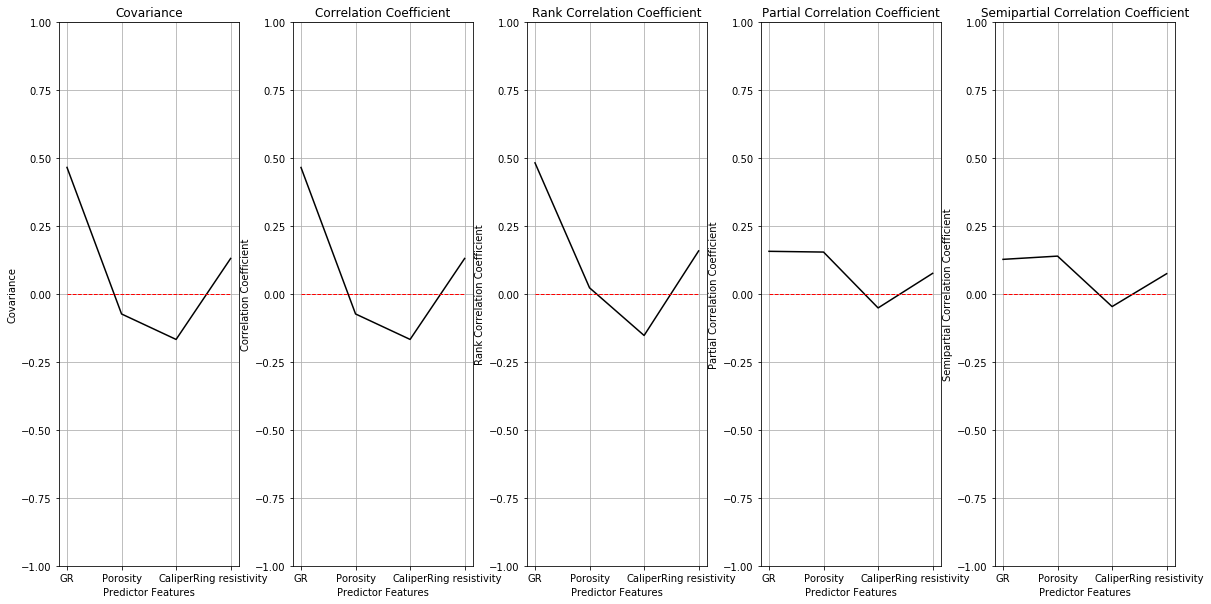

In [26]:
#Comparing different methods of feature ranking for SDT2

features = dfS.columns.values[1:][:4]
plt.subplot(151)
plt.plot(features,covariance2,color='black')
plt.plot([0.0,0.0,0.0,0.0],'r--',color='red',linewidth = 1.0)
plt.xlabel('Predictor Features')
plt.ylabel('Covariance')
t = plt.title('Covariance')
plt.ylim(-1,1)
plt.grid(True)

plt.subplot(152)
plt.plot(features,correlation2,color='black')
plt.plot([0.0,0.0,0.0,0.0],'r--',color='red',linewidth = 1.0)
plt.xlabel('Predictor Features')
plt.ylabel('Correlation Coefficient')
t = plt.title('Correlation Coefficient')
plt.ylim(-1,1)
plt.grid(True)

plt.subplot(153)
plt.plot(features,rank_correlation2,color='black')
plt.plot([0.0,0.0,0.0,0.0],'r--',color='red',linewidth = 1.0)
plt.xlabel('Predictor Features')
plt.ylabel('Rank Correlation Coefficient')
t = plt.title('Rank Correlation Coefficient')
plt.ylim(-1,1)
plt.grid(True)

plt.subplot(154)
plt.plot(features,partial_correlation2,color='black')
plt.plot([0.0,0.0,0.0,0.0],'r--',color='red',linewidth = 1.0)
plt.xlabel('Predictor Features')
plt.ylabel('Partial Correlation Coefficient')
t = plt.title('Partial Correlation Coefficient')
plt.ylim(-1,1)
plt.grid(True)

plt.subplot(155)
plt.plot(features,semipartial_correlation2,color='black')
plt.plot([0.0,0.0,0.0,0.0],'r--',color='red',linewidth = 1.0)
plt.xlabel('Predictor Features')
plt.ylabel('Semipartial Correlation Coefficient')
t = plt.title('Semipartial Correlation Coefficient')
plt.ylim(-1,1)
plt.grid(True)

plt.subplots_adjust(wspace=0.3, hspace=0.2)
plt.gcf().set_size_inches(20, 10)
plt.show()

It is also seen from the plots for SDT2 that GR is the most important variable for relationships, then Resistivity, Caliper and Porosity
***
#### Principal Component Analysis

Principal Component Analysis is one of a variety of methods for dimensional reduction. It is attempted to see if dimensionality reduction can capture the variance from the predictors in fewer features. This part of workflow adapted from Pyrcz (2019 b).


[0.33026365 0.30309071 0.24012011 0.12652553]


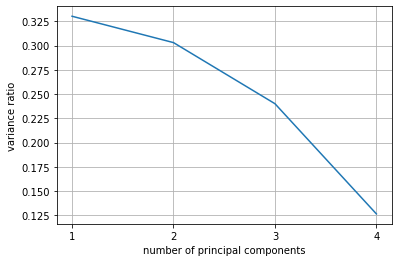

In [27]:
pca1 = PCA(n_components=4)
dfS1 = dfS.iloc[:,[1,2,3,4]] # all predictors

pca1.fit(dfS1)
#print(pca1.components_)
print(pca1.explained_variance_ratio_)
plt.plot(range(1,5), pca1.explained_variance_ratio_)
plt.xlabel("number of principal components")
plt.ylabel("variance ratio")
plt.xticks(np.arange(1,5,1))
plt.grid(True)

It is seen that 33% variance is captured in first principal component, 30% in second principal component, 24% in the third and 12% in the fourth. Since, there is no significant advantage by reducing the dimensions from four to three or two, hence, same dimensionality is retained going forward.
***
### Data Processing 

#### Moving window filter

Since there is noise (high resolution spatial variation) in the data which cannot be captured during the regression analysis, the logs are smoothened considering a window size of ~3 m to improve the model. This part of workflow adapted from Pyrcz (2019 c).

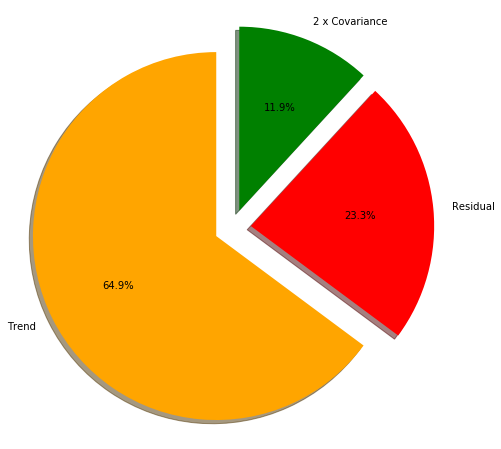

In [28]:
window_size = 21                        # assume window size in depth 3 m (Reduced vertical resolution to get better prediction)
                                        #Window size affecting R2.
#Determing rolling statistics
dfR = dfS.rolling(window = window_size, center = True).mean()

dfW = pd.DataFrame()
dfW['rolling_mean'] = dfR['GR'].values
dfW['residual'] = dfS['GR'].values - dfR['GR'].values
variance = np.var(dfS['GR'])
variance_trend = np.var(dfW['rolling_mean'])
variance_residual = np.var(dfW['residual'])
prop_trend = variance_trend/variance
prop_resid = variance_residual/variance
prop_cov = 1 - prop_trend - prop_resid
variance_prop = [prop_trend, prop_resid, prop_cov]
labels = 'Trend', 'Residual', '2 x Covariance'
colors = 'orange', 'red', 'green'
explode = (0.1, 0.1,0.1)
fig1, ax1 = plt.subplots()
ax1.pie(variance_prop, explode=explode, colors = colors, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.gcf().set_size_inches(8, 8)
plt.show()

It is seen that ~22% of the variance (residual) constitutes noise, i.e. short-distance variations and removing it can improve the regression model. 
***
#### Removing NaN values and summary statistics

In [29]:
# Remove NaN values introduced during the rolling progress
dfS=dfR
dfS=dfS.dropna()
dfS.describe()

,Depth,GR,Porosity,Caliper,Ring resistivity,MLT2_all_original,SD_all_original
count,2083.000000,2083.000000,2083.000000,2083.000000,2083.000000,2083.000000,2083.000000
mean,265.200000,0.012329,0.000694,-0.012861,0.003502,0.005418,-0.007498
std,91.661685,0.805539,0.898320,0.745023,0.885541,0.960039,0.956857
min,106.551600,-3.690536,-1.533112,-1.389231,-1.241244,-1.871986,-1.254430
25%,185.875800,-0.575328,-0.566549,-0.502525,-0.561911,-0.795357,-0.809888
50%,265.200000,0.074916,-0.236310,-0.146820,-0.302540,0.093659,-0.298371
75%,344.524200,0.665057,0.497770,0.330740,0.189756,0.705162,0.736868
max,423.848400,1.835041,3.318730,4.977468,4.484757,2.347170,2.341100


#### Plot smoothened logs

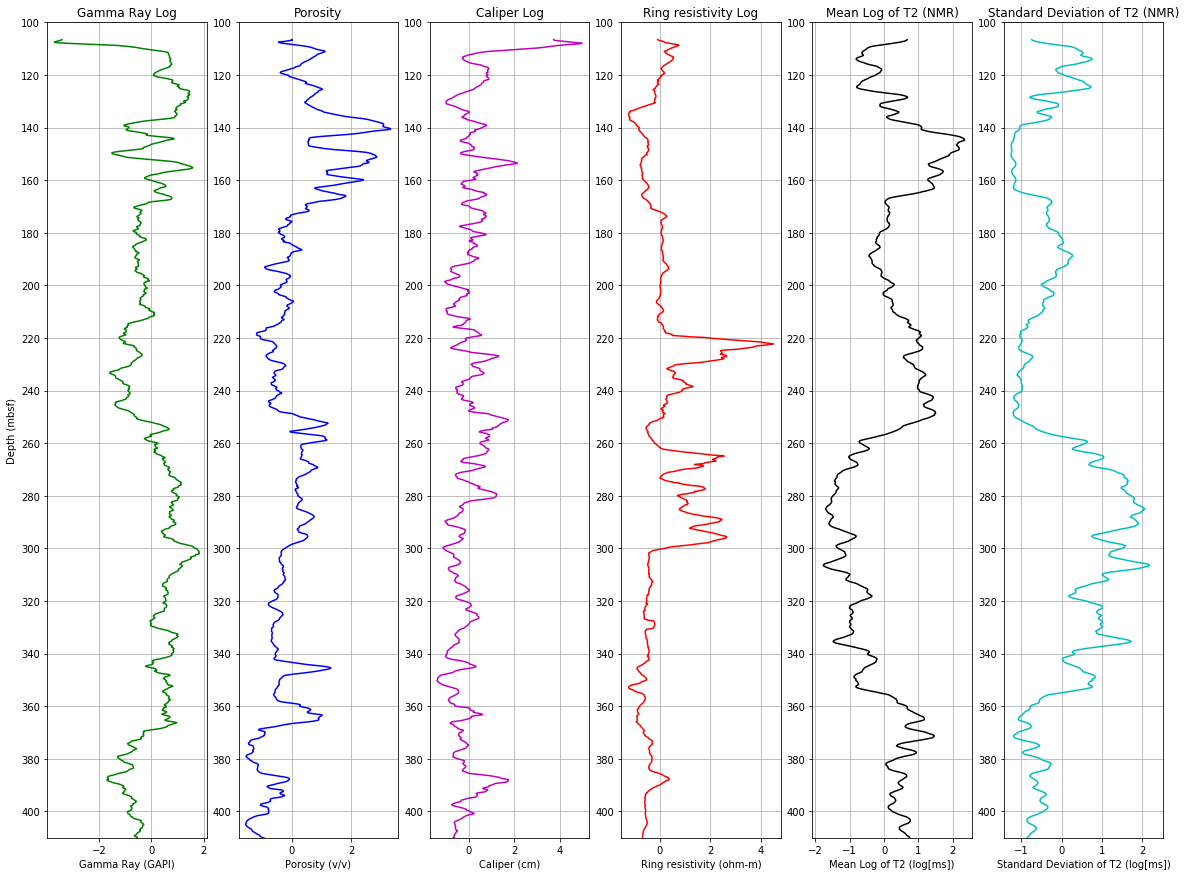

In [30]:
# Plot logs vs depth
plt.subplot(161)
plt.plot(dfR['GR'].values, dfR['Depth'].values,'g')
#plt.yscale('linear')
plt.title(grtitle)
plt.xlabel(grname)
plt.ylabel(depthname)
plt.yticks(np.arange(0, max(df['Depth'].values), 20.0))
plt.grid(True)
plt.ylim((100,410))
plt.gca().invert_yaxis()

plt.subplot(162)
plt.plot(dfR['Porosity'].values, dfR['Depth'].values,'b')
#plt.yscale('linear')
plt.title(portitle)
plt.xlabel(porname)
plt.yticks(np.arange(0, max(df['Depth'].values), 20.0))
plt.grid(True)
plt.ylim((100,410))
plt.gca().invert_yaxis()

plt.subplot(163)
plt.plot(dfR['Caliper'].values, dfR['Depth'].values,'m')
#plt.yscale('linear')
plt.title(caltitle)
plt.xlabel(calname)
plt.yticks(np.arange(0, max(df['Depth'].values), 20.0))
plt.grid(True)
plt.ylim((100,410))
plt.gca().invert_yaxis()

plt.subplot(164)
plt.plot(dfR['Ring resistivity'].values, dfR['Depth'].values,'r')
#plt.yscale('linear')
plt.title(restitle)
plt.xlabel(resname)
plt.yticks(np.arange(0, max(df['Depth'].values), 20.0))
plt.grid(True)
plt.ylim((100,410))
plt.gca().invert_yaxis()

plt.subplot(165)
plt.plot(dfR['MLT2_all_original'].values, dfR['Depth'].values,'k')
#plt.yscale('linear')
plt.title(mlt2title)
plt.xlabel(mlt2name)
plt.yticks(np.arange(0, max(df['Depth'].values), 20.0))
plt.grid(True)
plt.ylim((100,410))
plt.gca().invert_yaxis()

plt.subplot(166)
plt.plot(dfR['SD_all_original'].values, dfR['Depth'].values,'c')
#plt.yscale('linear')
plt.title(sdt2title)
plt.xlabel(sdt2name)
plt.yticks(np.arange(0, max(df['Depth'].values), 20.0))
plt.grid(True)
plt.ylim((100,410))
plt.gca().invert_yaxis()

plt.gcf().set_size_inches(20, 15)

It can be observed that the logs have been smoothened which will improve the regression fit.
***
#### Train-Test data split 

Before regression analysis, the log data is split into train and test parts in the ratio 80:20.

In [31]:
#Train-Test split
X_train, X_test, Y_train, Y_test = train_test_split(dfS.iloc[:,[0,1,2,3,4]],dfS.iloc[:,[0,5,6]], test_size=0.2)
print('Number of training data = ' + str(len(X_train)) + ' and number of testing data = ' + str(len(X_test)))
print('Total number of data = ' + str(len(dfS.iloc[:,[0]])))

Number of training data = 1666 and number of testing data = 417
Total number of data = 2083


#### Sort values according to depth

In [32]:
# Sort according to depth for plotting
X_train.sort_values(by=['Depth'], inplace=True)
Y_train.sort_values(by=['Depth'], inplace=True)
X_test.sort_values(by=['Depth'], inplace=True)
Y_test.sort_values(by=['Depth'], inplace=True)
#X_train.head()

****
### Polynomial Regression
****
Since non-linear reationships were observed in the variables during the feature ranking and bivariate analysis, hence polynomial regression was selected for creating a model. This part of workflow adapted from Pyrcz (2019 d).

#### Creating Hermite Table for MLT2 and SDT2 for Training data

Moreover, Hermite polynomials were used to reduce the correlation between the basis predictor features, and variables upto power 3 were used.

In [33]:
#Creating Hermite Table for MLT2 and SDT2 Training using all variables
orders3 = [0,1,2,3]
hermite_GR = scipy.special.eval_hermitenorm(orders3, X_train['GR'].values.reshape(-1, 1), out=None)
hermite_Porosity = scipy.special.eval_hermitenorm(orders3, X_train['Porosity'].values.reshape(-1, 1), out=None)
hermite_Caliper = scipy.special.eval_hermitenorm(orders3, X_train['Caliper'].values.reshape(-1, 1), out=None)
hermite_Resistivity = scipy.special.eval_hermitenorm(orders3, X_train['Ring resistivity'].values.reshape(-1, 1), out=None)

df_hermite = pd.DataFrame({'const': hermite_GR[:,0],'GR1': hermite_GR[:,1],'GR2': hermite_GR[:,2], 'GR3': hermite_GR[:,3], 'Por1': hermite_Porosity[:,1], 'Por2': hermite_Porosity[:,2], 'Por3': hermite_Porosity[:,3], 'Cal1': hermite_Caliper[:,1], 'Cal2': hermite_Caliper[:,2], 'Cal3': hermite_Caliper[:,3], 'Res1': hermite_Resistivity[:,1], 'Res2': hermite_Resistivity[:,2], 'Res3': hermite_Resistivity[:,3]}) # make a new DataFrame from the vectors

#df_hermite = pd.DataFrame({'GR0': hermite_GR[:,0],'GR1': hermite_GR[:,1],'GR2': hermite_GR[:,2], 'GR3': hermite_GR[:,3], 'Por0': hermite_Porosity[:,0], 'Por1': hermite_Porosity[:,1], 'Por2': hermite_Porosity[:,2], 'Por3': hermite_Porosity[:,3], 'Cal0': hermite_Caliper[:,0], 'Cal1': hermite_Caliper[:,1], 'Cal2': hermite_Caliper[:,2], 'Cal3': hermite_Caliper[:,3], 'Res0': hermite_Resistivity[:,0], 'Res1': hermite_Resistivity[:,1], 'Res2': hermite_Resistivity[:,2], 'Res3': hermite_Resistivity[:,3]}) # make a new DataFrame from the vectors
#df_hermite.head(10)

#### Covariance comparison after basis expansion

The below table shows that there is some correlation between variables at higher powers but it is minimized by using Hermite polynomials (a family of orthogonal polynomials)

In [34]:
#Covariance comparison between variables Training
df_hermite.iloc[:,0:].corr()

,const,GR1,GR2,GR3,Por1,Por2,Por3,Cal1,Cal2,Cal3,Res1,Res2,Res3
const,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
GR1,NaN,1.000000,-0.280782,-0.123335,0.276939,-0.134313,-0.297519,-0.371616,-0.300865,-0.292934,-0.082723,0.000188,-0.054261
GR2,NaN,-0.280782,1.000000,-0.721153,-0.034472,-0.015682,0.038760,0.422078,0.713366,0.714823,0.063697,-0.031515,-0.040279
GR3,NaN,-0.123335,-0.721153,1.000000,-0.129747,0.121079,0.170473,-0.327696,-0.670412,-0.692170,0.017189,0.026550,0.065037
Por1,NaN,0.276939,-0.034472,-0.129747,1.000000,0.593579,0.208585,0.272438,0.038706,-0.063078,-0.103131,0.003055,-0.039068
Por2,NaN,-0.134313,-0.015682,0.121079,0.593579,1.000000,0.790326,0.135420,-0.024640,-0.068925,-0.278751,-0.027232,0.037859
Por3,NaN,-0.297519,0.038760,0.170473,0.208585,0.790326,1.000000,0.024149,-0.013540,-0.022329,-0.196022,-0.013138,0.063556
Cal1,NaN,-0.371616,0.422078,-0.327696,0.272438,0.135420,0.024149,1.000000,0.644594,0.431973,0.081833,-0.067401,-0.111963
Cal2,NaN,-0.300865,0.713366,-0.670412,0.038706,-0.024640,-0.013540,0.644594,1.000000,0.928842,0.039903,-0.036729,-0.049150
Cal3,NaN,-0.292934,0.714823,-0.692170,-0.063078,-0.068925,-0.022329,0.431973,0.928842,1.000000,0.022871,-0.019666,-0.020461


#### Creating Hermite Table for MLT2 and SDT2 for Testing data

In [35]:
#Creating Hermite Table for MLT2 and SDT2 Testing using all variables

orders3 = [0,1,2,3]
hermite_GR = scipy.special.eval_hermitenorm(orders3, X_test['GR'].values.reshape(-1, 1), out=None)
hermite_Porosity = scipy.special.eval_hermitenorm(orders3, X_test['Porosity'].values.reshape(-1, 1), out=None)
hermite_Caliper = scipy.special.eval_hermitenorm(orders3, X_test['Caliper'].values.reshape(-1, 1), out=None)
hermite_Resistivity = scipy.special.eval_hermitenorm(orders3, X_test['Ring resistivity'].values.reshape(-1, 1), out=None)

df_hermite_test = pd.DataFrame({'const': hermite_GR[:,0],'GR1': hermite_GR[:,1],'GR2': hermite_GR[:,2], 'GR3': hermite_GR[:,3], 'Por1': hermite_Porosity[:,1], 'Por2': hermite_Porosity[:,2], 'Por3': hermite_Porosity[:,3], 'Cal1': hermite_Caliper[:,1], 'Cal2': hermite_Caliper[:,2], 'Cal3': hermite_Caliper[:,3], 'Res1': hermite_Resistivity[:,1], 'Res2': hermite_Resistivity[:,2], 'Res3': hermite_Resistivity[:,3]}) # make a new DataFrame from the vectors
#df_hermite_test = pd.DataFrame({'GR0': hermite_GR[:,0],'GR1': hermite_GR[:,1],'GR2': hermite_GR[:,2], 'GR3': hermite_GR[:,3], 'Por0': hermite_Porosity[:,0], 'Por1': hermite_Porosity[:,1], 'Por2': hermite_Porosity[:,2], 'Por3': hermite_Porosity[:,3], 'Cal0': hermite_Caliper[:,0], 'Cal1': hermite_Caliper[:,1], 'Cal2': hermite_Caliper[:,2], 'Cal3': hermite_Caliper[:,3], 'Res0': hermite_Resistivity[:,0], 'Res1': hermite_Resistivity[:,1], 'Res2': hermite_Resistivity[:,2], 'Res3': hermite_Resistivity[:,3]}) # make a new DataFrame from the vectors

#df_hermite_test.head()
#Covariance comparison between variables Testing
#df_hermite_test.iloc[:,0:].corr()

#### Model training

***
The regression model was trained to predict MLT2 and SDT2 using the Hermite polynomials

In [36]:
#Training MLT2
lin_herm = LinearRegression() 
lin_herm.fit(df_hermite.iloc[:,0:], Y_train['MLT2_all_original']) 
MLT2_herm_pred=lin_herm.predict(df_hermite)

MLT2_poly_pred= mlt2mean+(MLT2_herm_pred*mlt2sd) #Remove standardization
MLT2_S= mlt2mean+(Y_train['MLT2_all_original'].values*mlt2sd) #Remove standardization
print('Coefficient of regression (R2) for MLT2 Training')
r2_score(MLT2_S, MLT2_poly_pred)

Coefficient of regression (R2) for MLT2 Training


0.5279521973743193

In [37]:
#Training SDT2
lin_herm2 = LinearRegression() 
lin_herm2.fit(df_hermite.iloc[:,0:], Y_train['SD_all_original']) 
SDT2_herm_pred=lin_herm2.predict(df_hermite)

SDT2_poly_pred= sdt2mean+(SDT2_herm_pred*sdt2sd) #Remove standardization
SDT2_S= sdt2mean+(Y_train['SD_all_original'].values*sdt2sd) #Remove standardization
print('Coefficient of regression (R2) for SDT2 Training')
r2_score(SDT2_S, SDT2_poly_pred)

Coefficient of regression (R2) for SDT2 Training


0.5463350976364052

#### Model Testing

In [38]:
#Testing MLT2
MLT2_herm_pred_test=lin_herm.predict(df_hermite_test)
MLT2_poly_pred_test= mlt2mean+(MLT2_herm_pred_test*mlt2sd) #Remove standardization
MLT2_S_test= mlt2mean+(Y_test['MLT2_all_original'].values*mlt2sd) #Remove standardization
print('Coefficient of regression (R2) for MLT2 Testing')
r2_score(MLT2_S_test, MLT2_poly_pred_test)

Coefficient of regression (R2) for MLT2 Testing


0.5055416816626996

In [39]:
#Testing SDT2
SDT2_herm_pred_test=lin_herm2.predict(df_hermite_test)
SDT2_poly_pred_test= sdt2mean+(SDT2_herm_pred_test*sdt2sd) #Remove standardization
SDT2_S_test= sdt2mean+(Y_test['SD_all_original'].values*sdt2sd) #Remove standardization
print('Coefficient of regression (R2) for SDT2 Testing')
r2_score(SDT2_S_test, SDT2_poly_pred_test)

Coefficient of regression (R2) for SDT2 Testing


0.49787311562682013

It can be observed that the R2 values for training and testing for both MLT2 and SDT2 are comparable which shows that model variance and bias are balanced without overfit or udnerfit. This is better seen in the prediction comparison with actual data.
***
#### Comparison plots of well logs


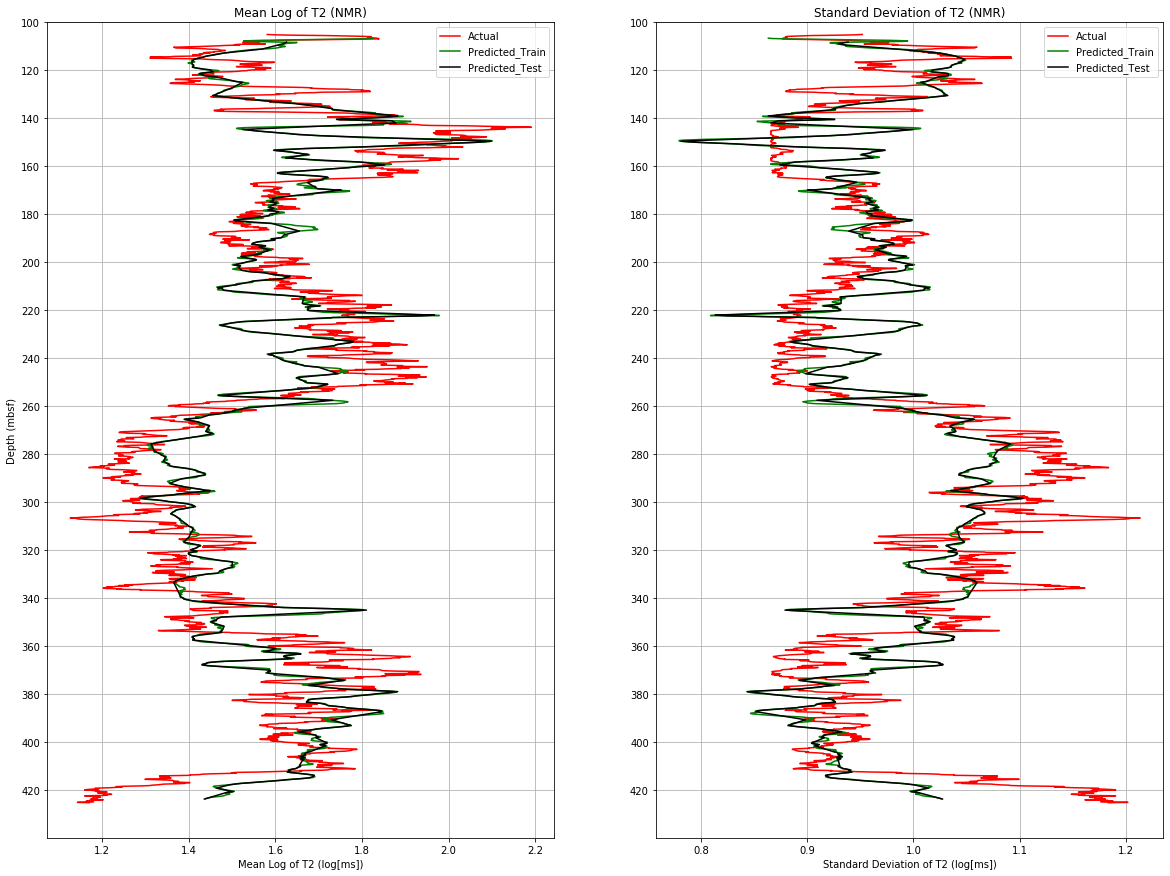

In [40]:
#Actual data comparison with train and test predictions

plt.subplot(121)
plt.plot(df_new['MLT2_all_original'].values, df_new['Depth'].values,'r',label='Actual')
plt.plot(MLT2_poly_pred, Y_train['Depth'].values,'g',label='Predicted_Train')
plt.plot(MLT2_poly_pred_test, Y_test['Depth'].values,'k',label='Predicted_Test')
plt.title(mlt2title)
plt.xlabel(mlt2name)
plt.ylabel(depthname)
plt.yticks(np.arange(0, max(df_new['Depth'].values), 20.0))
plt.grid(True)
plt.gca().set_ylim([100,440])
plt.gca().invert_yaxis()
plt.legend()

plt.subplot(122)
plt.plot(df_new['SD_all_original'].values, df_new['Depth'].values,'r',label='Actual')
plt.plot(SDT2_poly_pred, Y_train['Depth'].values,'g',label='Predicted_Train')
plt.plot(SDT2_poly_pred_test, Y_test['Depth'].values,'k',label='Predicted_Test')
plt.title(sdt2title)
plt.xlabel(sdt2name)
plt.yticks(np.arange(0, max(df_new['Depth'].values), 20.0))
plt.grid(True)
plt.gca().set_ylim([100,440])
plt.gca().invert_yaxis()
plt.legend()

plt.gcf().set_size_inches(20, 15)

It can be observed that the training and testing results overlap, and do a good job of capturing the actual log behavior.
***

### Prediction of Walker Ridge NMR log

The WR-313 log data is loaded, smoothened and data dissimilar to trained model is removed.


In [41]:
# Load WR data, smoothen it and remove data dissimilar to trained model.

df_WR = pd.read_csv(r'C:\Users\Abhishek\Desktop\python regression\WR313H_logs.csv')
df_WR = df_WR[df_WR['Depth'] < 800]  #remove all values > 800 mbsf as data is not similar to training data
df_WR = df_WR.rolling(window = 30, center = True).mean()
df_WR=df_WR.dropna()

#### Summary statistics

The summary statistics show that all the variables have values in the expected range and don't require truncation.

In [42]:
df_WR.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Depth,5044.0,413.383097,222.067509,2.362200,221.322900,413.461200,605.599500,797.737800
GR,5044.0,100.885515,7.403410,77.408048,94.409234,101.353413,106.912340,115.880903
Porosity,5044.0,0.370058,0.066106,0.276255,0.325644,0.350647,0.390833,0.826157
Caliper,5044.0,21.766212,0.333307,21.185632,21.567625,21.706798,21.850858,23.807843
Ring resistivity,5044.0,1.983267,0.689842,0.567267,1.588106,1.889100,2.219243,6.531423


#### Defining the minimum and maximum of variables 

In [43]:
#Defining the minimum and maximum of variables for plotting figures

pormin = df_WR['Porosity'].min(); pormax = df_WR['Porosity'].max(); porname = 'Porosity (v/v)'; portitle = 'Porosity' # user specified min and max values, and labels for plotting
grmin = df_WR['GR'].min(); grmax = df_WR['GR'].max(); grname = 'Gamma Ray (GAPI)'; grtitle = 'Gamma Ray Log' 
calmin = df_WR['Caliper'].min(); calmax = df_WR['Caliper'].max(); calname = 'Caliper (cm)'; caltitle = 'Caliper Log' 
resmin = df_WR['Ring resistivity'].min(); resmax = df_WR['Ring resistivity'].max(); resname = 'Ring resistivity (ohm-m)'; restitle = 'Ring resistivity Log' 
depthmin = df_WR['Depth'].min(); depthmax = df_WR['Depth'].max(); depthname = 'Depth (mbsf)'; depthtitle = 'Depth in meters below sea-floor (mbsf)' 


#### Plotting well logs with depth

All the well-logs are plotted with depth to see the spatial variation

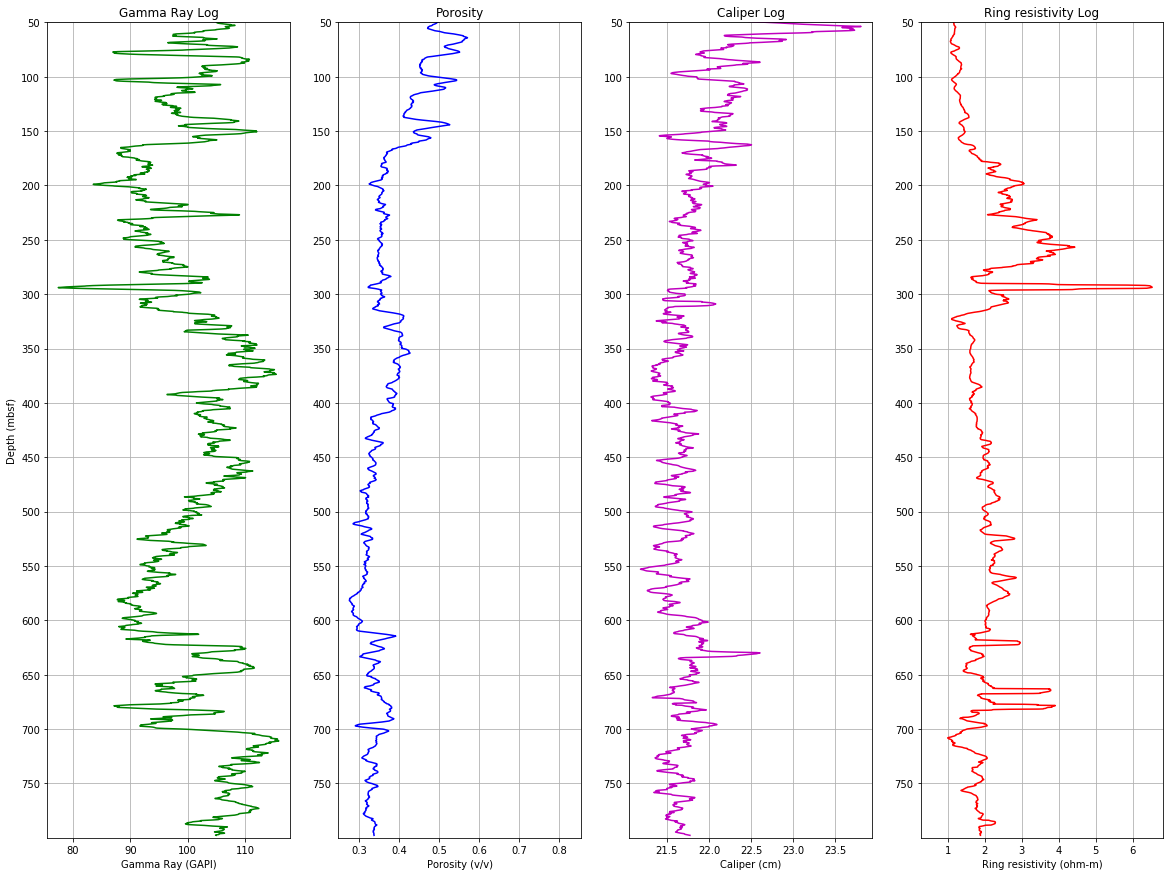

In [44]:
# Plot logs vs depth

plt.subplot(141)
plt.plot(df_WR['GR'].values, df_WR['Depth'].values,'g')
#plt.yscale('linear')
plt.title(grtitle)
plt.xlabel(grname)
plt.ylabel(depthname)
plt.yticks(np.arange(0, depthmax, 50.0))
plt.grid(True)
plt.gca().set_ylim([50,800])
plt.gca().invert_yaxis()

plt.subplot(142)
plt.plot(df_WR['Porosity'].values, df_WR['Depth'].values,'b')
#plt.yscale('linear')
plt.title(portitle)
plt.xlabel(porname)
plt.yticks(np.arange(0, depthmax, 50.0))
plt.grid(True)
plt.gca().set_ylim([50,800])
plt.gca().invert_yaxis()

plt.subplot(143)
plt.plot(df_WR['Caliper'].values, df_WR['Depth'].values,'m')
#plt.yscale('linear')
plt.title(caltitle)
plt.xlabel(calname)
plt.yticks(np.arange(0, depthmax, 50.0))
plt.grid(True)
plt.gca().set_ylim([50,800])
plt.gca().invert_yaxis()

plt.subplot(144)
plt.plot(df_WR['Ring resistivity'].values, df_WR['Depth'].values,'r')
#plt.xscale('log')
plt.title(restitle)
plt.xlabel(resname)
plt.yticks(np.arange(0, depthmax, 50.0))
plt.grid(True)
plt.gca().set_ylim([50,800])
plt.gca().invert_yaxis()


plt.gcf().set_size_inches(20, 15)

#### Plotting univariate distributions

It can be observed that the logs have been smoothened which will improve the regression fit.

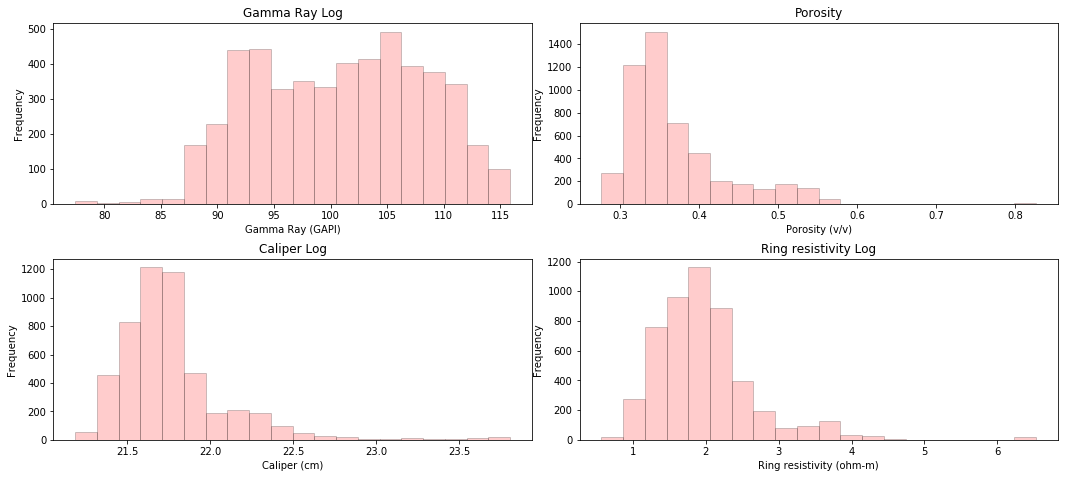

In [45]:
#Plotting univariate distributions

plt.subplot(321)
GSLIB.hist_st(df_WR['GR'].values, grmin, grmax, log=False, cumul = False,bins=20, weights = None, xlabel=grname, title=grtitle)

plt.subplot(322)
GSLIB.hist_st(df_WR['Porosity'].values,pormin,pormax,log=False,cumul = False,bins=20,weights = None,xlabel=porname,title=portitle)

plt.subplot(323)
GSLIB.hist_st(df_WR['Caliper'].values,calmin,calmax,log=False,cumul = False,bins=20,weights = None,xlabel=calname,title=caltitle)

plt.subplot(324)
GSLIB.hist_st(df_WR['Ring resistivity'].values,resmin,resmax,log=False,cumul = False,bins=20,weights = None, xlabel=resname, title=restitle)

plt.subplots_adjust(wspace=0.1, hspace=0.3)
plt.gcf().set_size_inches(18, 12)
plt.show()

The univariate distributions show that there are no obvious missing data, gaps, significant truncations, spikes or outliers.
****
#### Standardization
The variables are standardized before applying regression

In [46]:
#Standardization

dfS_WR = df_WR.copy()
depth=df_WR['Depth']
#scaler.fit(dfS_WR.drop('Depth',axis=1))
dfS1_WR = scaler.fit_transform(dfS_WR.drop('Depth', axis = 1)) # standardize all the values extracted from the DataFrame except Depth

dfS_WR = pd.DataFrame(dfS1_WR, index = dfS_WR.index, columns = dfS_WR.drop('Depth', axis = 1).columns)
dfS_WR.insert(0, 'Depth', depth)
dfS_WR.describe()

,Depth,GR,Porosity,Caliper,Ring resistivity
count,5044.000000,5.044000e+03,5.044000e+03,5.044000e+03,5.044000e+03
mean,413.383097,-1.514341e-17,-6.456748e-16,7.802355e-15,2.486886e-16
std,222.067509,1.000099e+00,1.000099e+00,1.000099e+00,1.000099e+00
min,2.362200,-3.171484e+00,-1.419118e+00,-1.742047e+00,-2.052847e+00
25%,221.322900,-8.748568e-01,-6.719275e-01,-5.958659e-01,-5.728848e-01
50%,413.461200,6.320660e-02,-2.936648e-01,-1.782732e-01,-1.365183e-01
75%,605.599500,8.141413e-01,3.143001e-01,2.539843e-01,3.421072e-01
max,797.737800,2.025671e+00,6.900203e+00,6.125980e+00,6.593694e+00


The values after standardization have a mean of 0 and std of 1 (except depth which is the reference)
***
#### Creating Hermite Table for MLT2 and SDT2 prediction

In [47]:
#Creating Hermite Table for MLT2 and SDT2 prediction using all variables

orders3 = [0,1,2,3]
hermite_GR = scipy.special.eval_hermitenorm(orders3, dfS_WR['GR'].values.reshape(-1, 1), out=None)
hermite_Porosity = scipy.special.eval_hermitenorm(orders3, dfS_WR['Porosity'].values.reshape(-1, 1), out=None)
hermite_Caliper = scipy.special.eval_hermitenorm(orders3, dfS_WR['Caliper'].values.reshape(-1, 1), out=None)
hermite_Resistivity = scipy.special.eval_hermitenorm(orders3, dfS_WR['Ring resistivity'].values.reshape(-1, 1), out=None)

df_hermite_WR = pd.DataFrame({'const': hermite_GR[:,0],'GR1': hermite_GR[:,1],'GR2': hermite_GR[:,2], 'GR3': hermite_GR[:,3], 'Por1': hermite_Porosity[:,1], 'Por2': hermite_Porosity[:,2], 'Por3': hermite_Porosity[:,3], 'Cal1': hermite_Caliper[:,1], 'Cal2': hermite_Caliper[:,2], 'Cal3': hermite_Caliper[:,3], 'Res1': hermite_Resistivity[:,1], 'Res2': hermite_Resistivity[:,2], 'Res3': hermite_Resistivity[:,3]}) # make a new DataFrame from the vectors
#df_hermite_WR.head()

#### Model prediction

The MLT2 and SDT2 at Walker Ridge were predicted using well logs at Walker Ridge and the model trained for Keathley Canyon log data.

In [48]:
#Polynomial regression for MLT2 using all variables

MLT2_herm_pred_WR=lin_herm.predict(df_hermite_WR)
MLT2_poly_pred_WR= mlt2mean+(MLT2_herm_pred_WR*mlt2sd) #Remove standardization

df_pred_MLT2_WR = pd.DataFrame(data=MLT2_poly_pred_WR)  
#df_pred_MLT2_WR.describe()

In [49]:
#Polynomial regression for SDT2 using all variables

SDT2_herm_pred_WR=lin_herm2.predict(df_hermite_WR)
SDT2_poly_pred_WR= sdt2mean+(SDT2_herm_pred_WR*sdt2sd) #Remove standardization

df_pred_SDT2_WR = pd.DataFrame(data=SDT2_poly_pred_WR)  
#df_pred_SDT2_WR.describe()

#### Plotting predicted well logs with depth

The predicted MLT2 and SDT2 from the regression model are plotted alongside the other logs. It can be seen that the behavior is in line with other logs, eg. at low GR ~290 mbsf, the MLT2 increases and SDT2 reduces due to a larger uniform pore size. 

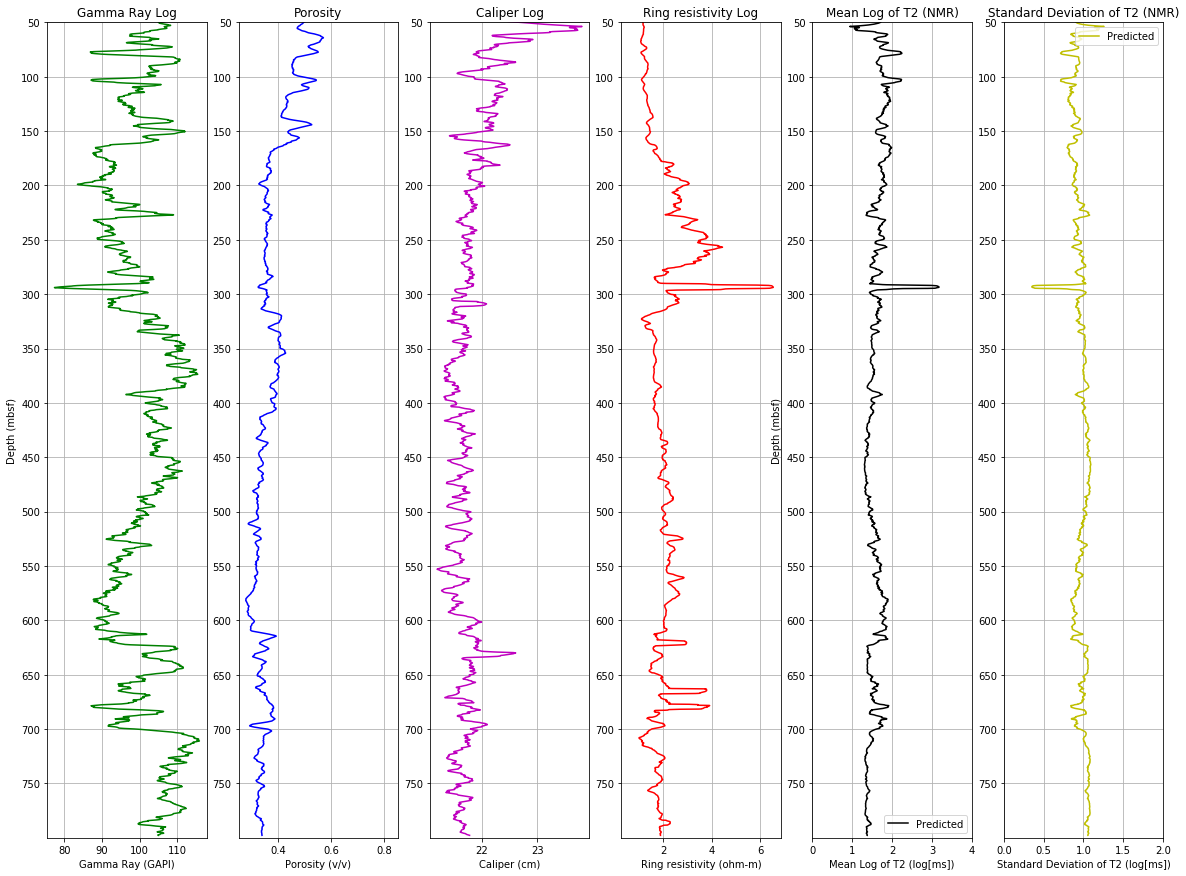

In [50]:
# Plot logs vs depth

plt.subplot(161)
plt.plot(df_WR['GR'].values, df_WR['Depth'].values,'g')
#plt.yscale('linear')
plt.title(grtitle)
plt.xlabel(grname)
plt.ylabel(depthname)
plt.yticks(np.arange(0, depthmax, 50.0))
plt.grid(True)
plt.gca().set_ylim([50,800])
plt.gca().invert_yaxis()

plt.subplot(162)
plt.plot(df_WR['Porosity'].values, df_WR['Depth'].values,'b')
#plt.yscale('linear')
plt.title(portitle)
plt.xlabel(porname)
plt.yticks(np.arange(0, depthmax, 50.0))
plt.grid(True)
plt.gca().set_ylim([50,800])
plt.gca().invert_yaxis()

plt.subplot(163)
plt.plot(df_WR['Caliper'].values, df_WR['Depth'].values,'m')
#plt.yscale('linear')
plt.title(caltitle)
plt.xlabel(calname)
plt.yticks(np.arange(0, depthmax, 50.0))
plt.grid(True)
plt.gca().set_ylim([50,800])
plt.gca().invert_yaxis()

plt.subplot(164)
plt.plot(df_WR['Ring resistivity'].values, df_WR['Depth'].values,'r')
#plt.xscale('log')
plt.title(restitle)
plt.xlabel(resname)
plt.yticks(np.arange(0, depthmax, 50.0))
plt.grid(True)
plt.gca().set_ylim([50,800])
plt.gca().invert_yaxis()

plt.subplot(165)
plt.plot(MLT2_poly_pred_WR, dfS_WR['Depth'].values,'k',label='Predicted')
plt.title(mlt2title)
plt.xlabel(mlt2name)
plt.ylabel(depthname)
plt.yticks(np.arange(0, max(df_WR['Depth'].values), 50.0))
plt.grid(True)
plt.gca().set_ylim([50,800])
plt.gca().set_xlim([0,4])
plt.gca().invert_yaxis()
plt.legend()

plt.subplot(166)
plt.plot(SDT2_poly_pred_WR, dfS_WR['Depth'].values,'y',label='Predicted')
plt.title(sdt2title)
plt.xlabel(sdt2name)
plt.yticks(np.arange(0, max(df_WR['Depth'].values), 50.0))
plt.grid(True)
plt.gca().set_ylim([50,800])
plt.gca().set_xlim([0,2])
plt.gca().invert_yaxis()
plt.legend()

plt.gcf().set_size_inches(20, 15)

Thus, the MLT2 and SDT2 (NMR log) can be successfully predicted using the workflow. The model can be further improved with more data from other wells and exploring other methods.